# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [1]:
import numpy as np
import skimage.io
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy

# Helper functions

In [2]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [86]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Find `num_matches` smallest indices in `dist` 
    # `indices` has the size of (num_matches, 2) where each row is (row, col) for `dist`
    indices_raw = dist.ravel().argsort()[:num_matches]
    indices = np.stack(np.unravel_index(indices_raw, dist.shape)).T

    # Find corresponding pixel location in `kp1` and `kp2`
    pt_pairs = np.empty((num_matches, 4))
    for i, idx in enumerate(indices):
        pt_pairs[i, 0:2] = kp1[idx[0]].pt
        pt_pairs[i, 2:4] = kp2[idx[1]].pt

    return pt_pairs

# https://github.com/hughesj919/HomographyEstimation/blob/master/Homography.py
def ransac(pt_pairs, num_iteration=100, threshold=1):
    inliers_best = np.empty((0,4))
    for n in range(num_iteration):
        #find 4 random points to calculate a homography
        candidates = pt_pairs[np.random.choice(pt_pairs.shape[0], 4)]

        #call the homography function on those points
        H = compute_homography(candidates)
        inliers = np.empty((0,4))

        for k in range(len(pt_pairs)):
            d = compute_reproj_error(pt_pairs[k], H)
            if d < threshold:
                inliers = np.append(inliers, pt_pairs[k][np.newaxis], axis=0)

        if len(inliers) > len(inliers_best):
            inliers_best = inliers
        max_inlier_ratio = len(inliers_best)/pt_pairs.shape[0]
        print(f"iteration: {n}, inlier ratio: , {len(inliers)/pt_pairs.shape[0]} (best:  {max_inlier_ratio})")

    # (optional) break condition

    # refine H
    H = compute_homography(inliers_best)

    return H, inliers_best, max_inlier_ratio

def compute_reproj_error(pt_pair, H):
    x0 = np.append(pt_pair[:2], 1)
    x1 = np.append(pt_pair[2:], 1)
    
    x1_proj = np.dot(H, x0)
    x1_proj /= x1_proj[-1]

    error = x1 - x1_proj
    return np.linalg.norm(error)

def compute_homography(pt_pairs):
    """
      param pt_pairs : (N, 4) shape np.array whose rows are of (pt1, pt2) correspondingly
      return H : (3, 3) shape np.array for estimated matrix
    """
    A = np.empty((0, 9))
    for pt in pt_pairs:
        x0 = np.append(pt[:2], 1)
        x1 = np.append(pt[2:], 1)
        A = np.append(A, np.concatenate([np.zeros(3), x0, -x1[1] * x0])[np.newaxis], axis=0)
        A = np.append(A, np.concatenate([x0, np.zeros(3), -x1[0] * x0])[np.newaxis], axis=0)
    
    #svd composition
    U, S, V = np.linalg.svd(A)

    #reshape the min singular value into a 3 by 3 matrix
    H = np.reshape(V[-1, :], (3, 3))

    #normalize and now we have H
    H /= H[-1, -1]
    return H

def warp_images(ax, img1, img2, H):
    H_inv = np.linalg.inv(H)

    img1_tmp = np.hstack([img1, np.zeros(img1.shape, dtype=np.uint8)])
    img2_tmp = cv2.warpPerspective(img2, H_inv, (2*img1.shape[1], img1.shape[0]))

    img1_mask = cv2.cvtColor(img1_tmp, cv2.COLOR_BGR2GRAY)
    img2_mask = cv2.cvtColor(img2_tmp, cv2.COLOR_BGR2GRAY)

    _, img1_mask = cv2.threshold(img1_mask, 0, 255, cv2.THRESH_BINARY)
    _, img2_mask = cv2.threshold(img2_mask, 0, 255, cv2.THRESH_BINARY)
    img2_mask_inv = cv2.bitwise_not(img2_mask)

    img1_roi = cv2.bitwise_and(img1_tmp, img1_tmp, mask=img2_mask_inv)
    img2_roi = cv2.bitwise_and(img2_tmp, img2_tmp, mask=img2_mask)
    res = cv2.addWeighted(img1_roi, 1., img2_roi, 1., 0)

    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    ax.axis('off')

# Main functions

#### Load images

In [12]:
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

#### Part (3) compute and display the initial SIFT matching result

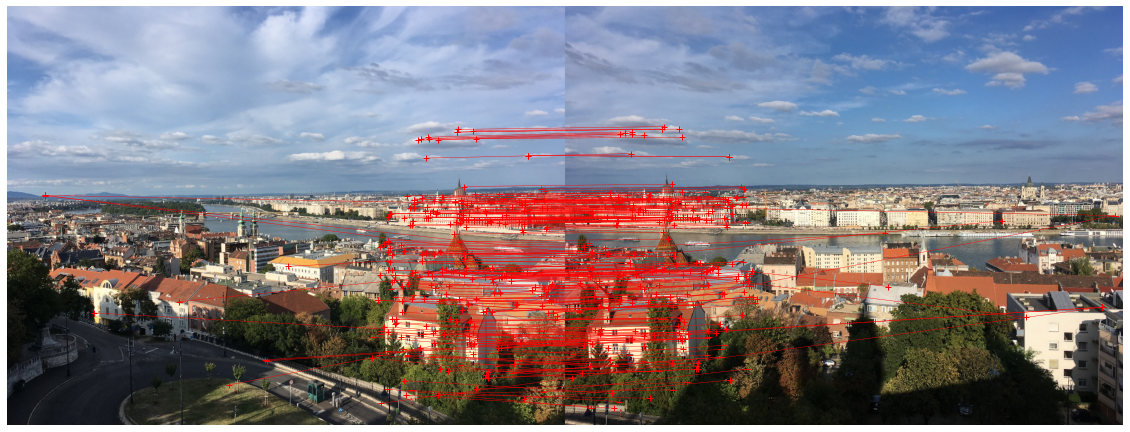

In [42]:
data = get_best_matches(img1, img2, 300)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.jpg', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

iteration: 0, inlier ratio: , 0.67 (best:  0.67)
iteration: 1, inlier ratio: , 0.03 (best:  0.67)
iteration: 2, inlier ratio: , 0.04 (best:  0.67)
iteration: 3, inlier ratio: , 0.21 (best:  0.67)
iteration: 4, inlier ratio: , 0.013333333333333334 (best:  0.67)
iteration: 5, inlier ratio: , 0.07666666666666666 (best:  0.67)
iteration: 6, inlier ratio: , 0.4766666666666667 (best:  0.67)
iteration: 7, inlier ratio: , 0.30333333333333334 (best:  0.67)
iteration: 8, inlier ratio: , 0.23 (best:  0.67)
iteration: 9, inlier ratio: , 0.013333333333333334 (best:  0.67)
iteration: 10, inlier ratio: , 0.18333333333333332 (best:  0.67)
iteration: 11, inlier ratio: , 0.38333333333333336 (best:  0.67)
iteration: 12, inlier ratio: , 0.49 (best:  0.67)
iteration: 13, inlier ratio: , 0.31333333333333335 (best:  0.67)
iteration: 14, inlier ratio: , 0.12666666666666668 (best:  0.67)
iteration: 15, inlier ratio: , 0.19666666666666666 (best:  0.67)
iteration: 16, inlier ratio: , 0.12 (best:  0.67)
iteration

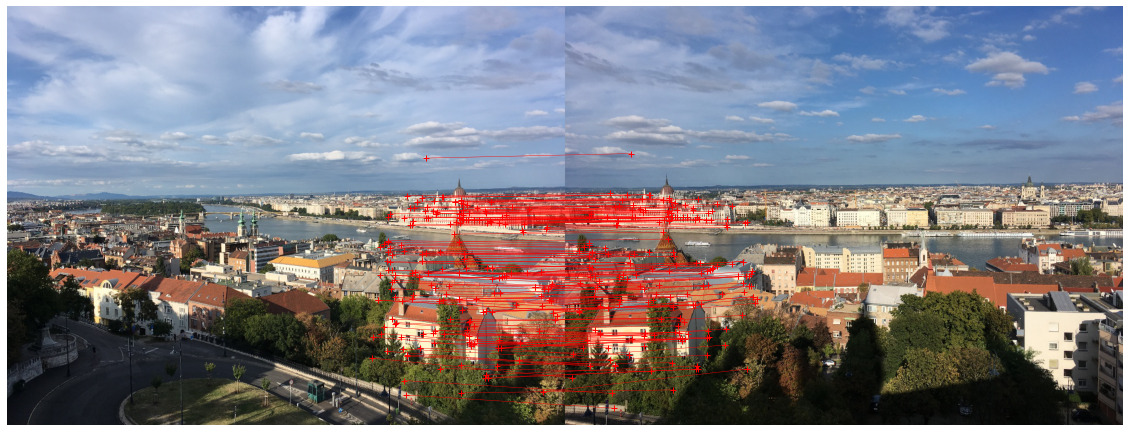

In [43]:
# display the inlier matching, report the average residual
H, data_ransac, max_inliers = ransac(data)
# print("Average residual:", np.average(best_model_errors))
print("Inliers:", max_inliers)

fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data_ransac)
fig.savefig('ransac_match.jpg', bbox_inches='tight')

#### Part (5) warp images to stitch them together

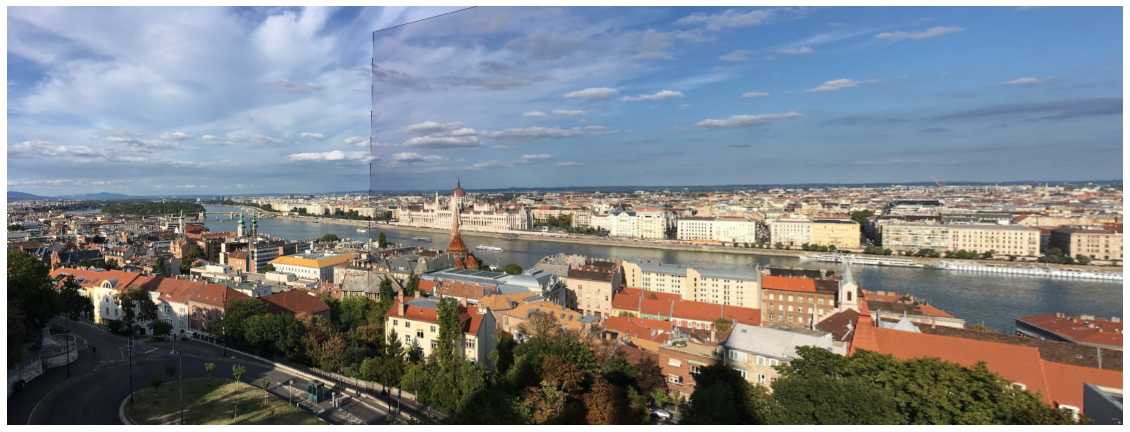

In [88]:
fig, ax = plt.subplots(figsize=(20,10))
warp_images(ax, img1, img2, H)


##
fig.savefig('stitched_images.jpg', bbox_inches='tight')
# display and report the stitching results
# <YOUR CODE>
# cv2.imwrite('stitched_images.jpg', im[:,:,::-1]*255., 
#             [int(cv2.IMWRITE_JPEG_QUALITY), 90])